In [173]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import datetime as dt
from sklearn import preprocessing
pd.set_option('display.max_columns', None)



# stats tests 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import datasets


In [174]:
#read the data
dataframe = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])
data=dataframe.copy()

In [175]:
# This turns the No-show variable into a binary of 1 and 0, 1 means a no-show.  
data['Alvo'] = data['No-show'].apply(lambda x: 1 if x == 'Yes' else 0)

Handicap and Gender

In [176]:
data['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [177]:
# binarizing handicap and Gender
data['handicap']= data['Handcap'].apply(lambda x: 0 if x==0 else 1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)


Date tratament

In [178]:
# Create a column that is the day of the week of the appointment 
data["week_day"] = data["AppointmentDay"].dt.dayofweek
# create a column for the time between when a patient scheduled the appointment to the appointment.
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date).dt.days
#print("Dias consultas", data["week_day"].value_counts())
#print("Tempo de espera negativo:", data[data["wait"]<0].count())
# drop negative wait time rows and the Saturday appointments as they are clearly outliers. 
data= data[data["week_day"] != "Saturday"]
data = data[data['wait'] >= 0]

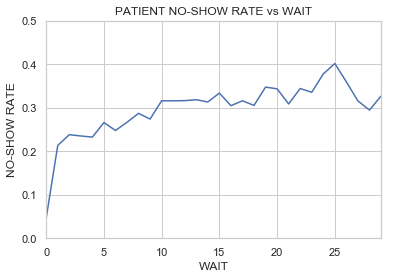

In [179]:
# create a plot of no-show rate compared to the appointment's wait, discovering breaks to better discretize data. Since
#we  don't  have a better semantical choice
data.groupby('wait').mean().Alvo[:30].plot()
plt.title("PATIENT NO-SHOW RATE vs WAIT")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("WAIT")
plt.ylim(0,.50)
plt.show()

In [180]:
#we observed a big increase up to two days, then the non-attendance rate increases again in 5 days until the tenth day. After that, you have
#a smooth change and maintain same average until the 21. Have another interval in 25 days.

def bin_wait_time(df):
                        # bin ranges 0, 1, 2-4, 5-10, 10-21, 25 < 
    col="wait"
    if df[col]   <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <5:
        return 3
    elif df[col] <10:
        return 7
    elif df[col] < 21:
        return 16
    elif df[col] < 25:
        return 20
    else: 
        return 25

In [181]:
#create wait_binned
data["wait_binned"]= data.apply(bin_wait_time, axis=1)

Age Analysis

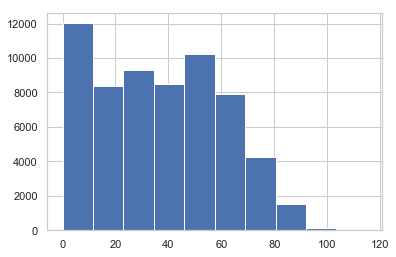

In [182]:
data.drop_duplicates('PatientId')['Age'].hist()

In [183]:
# filter out negative age
data = data[data.Age >=0]

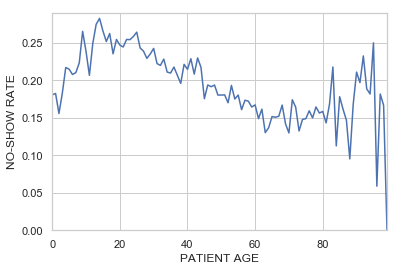

In [184]:
# create a plot of no-show rate compared to the patients age, discovering breaks to discretize data
data.groupby('Age').mean().Alvo[:100].plot()
plt.ylabel("NO-SHOW RATE")
plt.xlabel("PATIENT AGE")
plt.ylim(0,.29)
plt.show()
#data.groupby('appointment_day')[["no_show_bi"]].mean()

In [185]:
#Discretize data in changes directions of graph. It is easiest to realize it in table. Not showed here. 
def bin_age(df):
    '''Creates a function to turn age into 6 groups of binned ages.'''
                        # bin ranges 0-3, 4-7, 8-27, 28-40, 41-60, 61 < 
    if df["Age"] <4:
        return 2
    elif df["Age"] <8:
        return 5
    elif df["Age"] <28:
        return 16
    elif df["Age"] <41:
        return 34
    elif df["Age"] <61:
        return 51
    else:
        return 70

In [191]:
# apply binning function
data["age_binned"]= data.apply(bin_age, axis=1)

Zones and Neighbourhood analysis

In [196]:
# adding another column with zones neighbourhoods
dataframeZone={}
dataframeZone=pd.read_csv( "regiao_adm.csv", delimiter="," )
dataframeZone["Neighbourhood"]=dataframeZone["Neighbourhood"].apply(lambda x: x.upper().strip())
data['Neighbourhood']=data['Neighbourhood'].apply(lambda x: x.upper().strip())
data=pd.merge(data, dataframeZone, on='Neighbourhood', how='left')


In [197]:
# Order the zones by the mean income - data of 2010 (http://legado.vitoria.es.gov.br/regionais/dados_regiao/regiao_9/regiao9d.asp)
def order_zone(df):
    col='Adm_Zone'
    if df[col] =="VII – São Pedro":
        return 1
    elif df[col] == "II - Santo Antônio":
        return 2
    elif df[col] == "IV – Maruípe":
        return 3
    elif df[col] =="VI – Continente":
        return 4
    elif df[col] =="III - Bento Ferreira/Jucutuquara":
        return 5
    elif df[col] =="I – Centro":
        return 6
    else:
        return 7


In [198]:
data["order_zone"]= data.apply(order_zone, axis=1)

In [199]:
#frequency
data.drop_duplicates('PatientId')['order_zone'].value_counts()

4    13468
3    12667
1     9819
2     8970
5     7158
7     5225
6     4992
Name: order_zone, dtype: int64

In [200]:
#x= data[data['PatientId']=='7414864771918']

Behavior Patient - Temporal Features

In [201]:
#previous number of no-shows
def behavior_noshow(row):
        appointment_passed = data.loc[(data.PatientId == row.PatientId) & (data.Alvo==0)& (data.AppointmentDay < row.AppointmentDay), 'Alvo']
        noshow_passed = data.loc[(data.PatientId == row.PatientId) & (data.AppointmentDay < row.AppointmentDay), 'Alvo']

        #print(consultas_passado)
        row["n_appoint_passed"] = len(appointment_passed)
        row["n_noshow_passed"] = noshow_passed.sum()
        return row

In [202]:
#embbeded more informations about time. State last patient's appointments. For those who are on your first appoitment was created dummy feature.
data = data.sort_values(by = ['AppointmentDay', 'ScheduledDay'], axis = 0)
data['stat_last_app'] = data.groupby('PatientId')['Alvo'].apply(lambda x : x.shift(1))
#keep the original feature, with no-show and first_appointment mixed, to make tests 
data['stat_last_app_ori'] = data['stat_last_app'].fillna(0)
# create new dummy that indicate if is the first pacient's appointment, and kepp only the dummy that show if patient failed your last appointment
data['stat_last_app'].fillna("First", inplace=True)
data=pd.get_dummies(data=data, columns=['stat_last_app'])
data.drop(['stat_last_app_0.0','stat_last_app_1.0'],inplace=True, axis=1)



In [203]:
data=data.apply(behavior_noshow, axis=1)

In [268]:
data=pd.read_csv("temp.csv", parse_dates=["AppointmentDay", "ScheduledDay"])


/Users/rogerio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [269]:
data["n_appoint_passed"].value_counts()

0     71588
1     21137
2      8365
3      3616
4      1783
5      1000
6       655
7       407
8       284
9       225
10      135
11      123
12       87
13       76
14       61
15       56
32       45
16       45
17       39
25       38
21       37
27       36
18       35
24       33
23       30
19       29
22       28
20       27
29       26
39       24
      ...  
49       15
44       14
34       14
40       13
42       13
58       12
45       11
46       11
47       11
48       10
54       10
41        9
33        9
57        9
52        9
74        8
36        8
56        7
72        6
70        6
82        5
78        4
59        4
61        4
53        3
55        3
62        3
67        3
60        3
63        1
Name: n_appoint_passed, Length: 71, dtype: int64

In [270]:
def bin_no_appointment_passed(df):
    col="n_appoint_passed"
    if df[col]  <1:
        return "0"
    elif df[col] <2:
        return "1"
    elif df[col] <3:
        return "2"
    else: 
        return "3ormore"

In [271]:
data["n_appoint_passed_bin"]= data.apply(bin_no_appointment_passed, axis=1)

In [277]:
data['n_appoint_passed_bin'].value_counts()

0          71588
1          21137
3ormore     9432
2           8365
Name: n_appoint_passed_bin, dtype: int64

In [278]:
# How many people has 0 no-show and are in your first appointment? The no-show increase only finished next appointment
#print('frequency number no-show\n'
#      ,data['n_noshow_passed'].value_counts())
print(((data['n_noshow_passed']==0) & (data['stat_last_app_First']==1)).sum(),'out of',(data['n_noshow_passed'] ==0).sum(),'patients who never failed, are on your first appointment')

62299 out of 96408 patients who never failed, are on your first appointment


In [279]:
data['n_noshow_passed'].value_counts()

0     96408
1     10474
2      2366
3       696
4       286
5       126
6        58
8        26
7        26
9        24
10       11
11       10
13        4
15        3
12        3
14        1
Name: n_noshow_passed, dtype: int64

In [280]:
#in this case, i will keep two different collunmns to not mixed the patients with no historic no-shows and there are on your first appointment. 
#split who never failed, have one fail and 2 or more (decison made by frequency)
def bin_no_show_passed(df):
    col="n_noshow_passed"
    if df[col] < 1:
        return "0"
    elif df[col] <2:
        return "1"
    else: 
        return "2ormore"

In [281]:
data["n_noshow_passed_bin"]= data.apply(bin_no_show_passed, axis=1)

In [282]:
data["n_noshow_passed_bin"].value_counts()

0          96408
1          10474
2ormore     3640
Name: n_noshow_passed_bin, dtype: int64

In [283]:
#todas variaveis disponiveis
data.columns



Index(['Unnamed: 0', 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'Alvo',
       'handicap', 'week_day', 'wait', 'wait_binned', 'age_binned',
       'Adm_Zone_x', 'order_zone', 'Adm_Zone_y', 'Adm_Zone',
       'stat_last_app_ori', 'stat_last_app_First', 'n_appoint_passed',
       'n_noshow_passed', 'no-show-passed-bin', 'n_appoint_passed_bin',
       'n_noshow_passed_bin'],
      dtype='object')

In [297]:
#category to dummy creation
conjunto1_dummy =['age_binned', "Adm_Zone", "week_day"]
conjunto2_dummy=['age_binned','Adm_Zone','week_day', 'wait_binned','n_noshow_passed_bin','n_appoint_passed_bin' ]
#numerics to normalization - [0-1]
conjunto1_numerical=["wait", 'n_noshow_passed', "n_appoint_passed"]
#binary. Keep on
conjunto1_binary=["Gender","Scholarship", "Hipertension","Diabetes","Alcoholism","handicap","SMS_received", 'stat_last_app_First','stat_last_app_ori',"Alvo"]
conjunto2_binary=["Gender","Scholarship", "Hipertension","Diabetes","Alcoholism","handicap","SMS_received", 'stat_last_app_First','stat_last_app_ori',"Alvo"]

date_to_split = ["AppointmentDay"]
#creating dummy...
conjunto1 = data[conjunto1_dummy + conjunto1_numerical + conjunto1_binary + date_to_split]
conjunto1 = pd.get_dummies(conjunto1, columns=(conjunto1_dummy), drop_first=True)

conjunto2 = data[conjunto2_dummy + conjunto1_binary + date_to_split]
conjunto2 = pd.get_dummies(conjunto2, columns=(conjunto2_dummy), drop_first=True)
#escaling..
n_test = conjunto1[conjunto1_numerical]
x = n_test.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
n_test = pd.DataFrame(x_scaled, columns=conjunto1_numerical)
l_test = conjunto1.drop(conjunto1_numerical, axis=1)
conjunto1 = pd.concat([n_test, l_test], axis=1)
conjunto2.columns

/Users/rogerio/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Index(['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism',
       'handicap', 'SMS_received', 'stat_last_app_First', 'stat_last_app_ori',
       'Alvo', 'AppointmentDay', 'age_binned_5', 'age_binned_16',
       'age_binned_34', 'age_binned_51', 'age_binned_70',
       'Adm_Zone_II - Santo Antônio',
       'Adm_Zone_III - Bento Ferreira/Jucutuquara', 'Adm_Zone_IV – Maruípe',
       'Adm_Zone_V – Praia do Canto', 'Adm_Zone_VI – Continente',
       'Adm_Zone_VII – São Pedro', 'week_day_1', 'week_day_2', 'week_day_3',
       'week_day_4', 'week_day_5', 'wait_binned_1', 'wait_binned_3',
       'wait_binned_7', 'wait_binned_16', 'wait_binned_20', 'wait_binned_25',
       'n_noshow_passed_bin_1', 'n_noshow_passed_bin_2ormore',
       'n_appoint_passed_bin_1', 'n_appoint_passed_bin_2',
       'n_appoint_passed_bin_3ormore'],
      dtype='object')

In [242]:
conjunto1.head(1)

,wait,n_noshow_passed,n_appoint_passed,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_app_First,stat_last_app_ori,Alvo,AppointmentDay,age_binned_5,age_binned_16,age_binned_34,age_binned_51,age_binned_70,Adm_Zone_II - Santo Antônio,Adm_Zone_III - Bento Ferreira/Jucutuquara,Adm_Zone_IV – Maruípe,Adm_Zone_V – Praia do Canto,Adm_Zone_VI – Continente,Adm_Zone_VII – São Pedro,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5
0,0.642458,0.0,0.0,1,0,1,1,0,1,1,1,0.0,0,2016-04-29 00:00:00+00:00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [298]:
conjunto2.head(1)

,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_app_First,stat_last_app_ori,Alvo,AppointmentDay,age_binned_5,age_binned_16,age_binned_34,age_binned_51,age_binned_70,Adm_Zone_II - Santo Antônio,Adm_Zone_III - Bento Ferreira/Jucutuquara,Adm_Zone_IV – Maruípe,Adm_Zone_V – Praia do Canto,Adm_Zone_VI – Continente,Adm_Zone_VII – São Pedro,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,wait_binned_1,wait_binned_3,wait_binned_7,wait_binned_16,wait_binned_20,wait_binned_25,n_noshow_passed_bin_1,n_noshow_passed_bin_2ormore,n_appoint_passed_bin_1,n_appoint_passed_bin_2,n_appoint_passed_bin_3ormore
0,1,0,1,1,0,1,1,1,0.0,0,2016-04-29 00:00:00+00:00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [243]:
conjunto1.describe()

,wait,n_noshow_passed,n_appoint_passed,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_app_First,stat_last_app_ori,Alvo,age_binned_5,age_binned_16,age_binned_34,age_binned_51,age_binned_70,Adm_Zone_II - Santo Antônio,Adm_Zone_III - Bento Ferreira/Jucutuquara,Adm_Zone_IV – Maruípe,Adm_Zone_V – Praia do Canto,Adm_Zone_VI – Continente,Adm_Zone_VII – São Pedro,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5
count,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,0.056895,0.012299,0.012097,0.350021,0.098270,0.197255,0.071868,0.030401,0.020258,0.321040,0.563680,0.090769,0.201896,0.051890,0.240477,0.175739,0.272172,0.178797,0.141999,0.118601,0.199897,0.036825,0.212247,0.163044,0.231972,0.234035,0.156041,0.172083,0.000353
std,0.085224,0.040815,0.044118,0.476978,0.297681,0.397928,0.258270,0.171689,0.140884,0.466878,0.495931,0.287282,0.401417,0.221806,0.427375,0.380599,0.445080,0.383184,0.349051,0.323320,0.399924,0.188333,0.408901,0.369408,0.422093,0.423396,0.362896,0.377455,0.018782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.022346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.083799,0.000000,0.012195,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


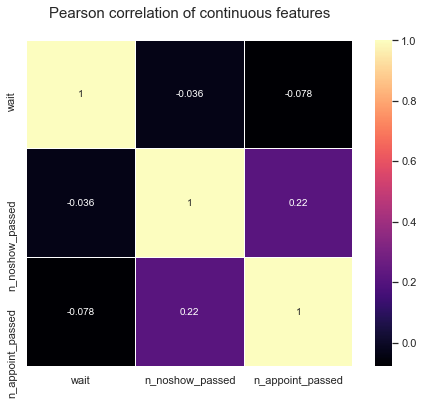

In [244]:
colormap = plt.cm.magma
plt.figure(figsize=(8,6))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(data[conjunto1_numerical].corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [245]:
conjunto1_train = conjunto1[(conjunto1.AppointmentDay< '2016-05-29')& (conjunto1.AppointmentDay>='2016-04-29')]
conjunto1_test = conjunto1[conjunto1.AppointmentDay >  '2016-05-29']

In [299]:
conjunto2_train = conjunto2[(conjunto2.AppointmentDay< '2016-05-29')& (conjunto2.AppointmentDay>='2016-04-29')]
conjunto2_test = conjunto2[conjunto2.AppointmentDay >  '2016-05-29']

In [246]:
conjunto1_train.drop('AppointmentDay', inplace=True, axis=1)
conjunto1_test.drop('AppointmentDay', inplace=True, axis=1)

/Users/rogerio/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [300]:
conjunto2_train.drop('AppointmentDay', inplace=True, axis=1)
conjunto2_test.drop('AppointmentDay', inplace=True, axis=1)

/Users/rogerio/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [293]:
conjunto1_train.head(1)

,wait,n_noshow_passed,n_appoint_passed,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_app_First,stat_last_app_ori,Alvo,age_binned_5,age_binned_16,age_binned_34,age_binned_51,age_binned_70,Adm_Zone_II - Santo Antônio,Adm_Zone_III - Bento Ferreira/Jucutuquara,Adm_Zone_IV – Maruípe,Adm_Zone_V – Praia do Canto,Adm_Zone_VI – Continente,Adm_Zone_VII – São Pedro,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5
0,0.642458,0.0,0.0,1,0,1,1,0,1,1,1,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [301]:
conjunto2_train.head(1)

,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_app_First,stat_last_app_ori,Alvo,age_binned_5,age_binned_16,age_binned_34,age_binned_51,age_binned_70,Adm_Zone_II - Santo Antônio,Adm_Zone_III - Bento Ferreira/Jucutuquara,Adm_Zone_IV – Maruípe,Adm_Zone_V – Praia do Canto,Adm_Zone_VI – Continente,Adm_Zone_VII – São Pedro,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,wait_binned_1,wait_binned_3,wait_binned_7,wait_binned_16,wait_binned_20,wait_binned_25,n_noshow_passed_bin_1,n_noshow_passed_bin_2ormore,n_appoint_passed_bin_1,n_appoint_passed_bin_2,n_appoint_passed_bin_3ormore
0,1,0,1,1,0,1,1,1,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
#database.dtypes

In [249]:
print("Alvo Train:", (conjunto_train['Alvo']==1).sum()/(conjunto1_train['Alvo'].count()))
print("Alvo Test:",(conjunto1_test['Alvo']==1).sum()/(conjunto1_test['Alvo'].count()))


Alvo Train: 0.20958314514200696
Alvo Test: 0.18547837929860403


In [302]:
print("Alvo Train:", (conjunto2_train['Alvo']==1).sum()/(conjunto2_train['Alvo'].count()))
print("Alvo Test:",(conjunto2_test['Alvo']==1).sum()/(conjunto2_test['Alvo'].count()))


Alvo Train: 0.20958314514200696
Alvo Test: 0.18547837929860403


In [250]:
conjunto1_train.to_csv('rlcsf_cj1_train.csv', sep=',')
conjunto1_test.to_csv('rlcsf_cj1_test.csv', sep=',')

In [303]:
conjunto2_train.to_csv('rlcsf_cj2_train.csv', sep=',')
conjunto2_test.to_csv('rlcsf_cj2_test.csv', sep=',')

In [ ]:
# create a plot of no-show rate compared to the patients age, discovering breaks to discretize data
#data.groupby('AppointmentDay').mean().Alvo[:30].plot()
#plt.title("PATIENT NO-SHOW RATE vs TIME")
#plt.ylabel("NO-SHOW RATE")
#plt.xlabel("DAYS")
#plt.ylim(0,.99)
#plt.show()
#data2['n_No-show_passed'].describe()

In [ ]:
#data.head(10)

In [ ]:
#train = train[train['Alvo']==0].sample(frac=.8)

In [ ]:
#train.to_csv('trainrlcsf.csv', sep=',')
#teste.to_csv('testerlcsf.csv', sep=',')